# 載入資料

In [ ]:
!gdown --id '1N966AV3Gl_rCT1USbih-PMn9g_eEAp1O' --output taoyuan.csv

Downloading...
From: https://drive.google.com/uc?id=1N966AV3Gl_rCT1USbih-PMn9g_eEAp1O
To: /content/taoyuan.csv
100% 178M/178M [00:00<00:00, 182MB/s]


# 引入套件

In [ ]:
%%capture
!pip install linearmodels
import linearmodels as plm

In [ ]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [ ]:
%%capture
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 變數
[道路交通事故調查報告表](https://ir.nctu.edu.tw/bitstream/11536/59224/6/652806.pdf)

## 時間變數

```
occur_datetime: 發生日期時間
start_datetime: 到場處理日期時間
end_datetime: 事件排除日期時間
```

## 事件變數

```
acc_type: 事故類別名稱
county: 發生縣市名稱
town: 發生市區鄉鎮名稱
death24_num: 死亡人數_24小時內
death30_num: 死亡人數_2_30日內
hurt_num: 受傷人數
weather: 天候名稱
light: 光線名稱
road_type: 道路第1當事者_名稱
speed_limit: 速限_第1當事者
location_type: 事故位置大類別名稱
obstacle: 道路障礙_障礙物名稱
accident_type: 事故類型及型態大類別名稱
accident_subtype: 事故類型及型態子類別名稱
cause_type: 肇因研判大類別名稱_主要
cause_subtype: 肇因研判子類別名稱_主要
```


## 當事人變數

```
party_order: 當事者順位
nation: 國籍
sex: 當事者屬性別名稱
age: 當事者事故發生時年齡
vehicle_type: 乘坐車輛的當事者區分_大類別名稱_車種
vehicle_subtype: 乘坐車輛的當事者區分_子類別名稱_車種
injure_type: 受傷程度名稱
use_phone: 行動電話_電腦或其他相類功能裝置名稱
action_type: 當事者行動狀態子類別名稱
driver_qualification: 駕駛資格情形名稱
license_type: 駕駛執照種類大類別名稱
license_subtype: 駕駛執照種類子類別名稱
drink: 飲酒情形名稱
hit_and_run: 肇事逃逸類別名稱_是否肇逃
```


# DataFrame

In [ ]:
df = pd.read_csv('taoyuan.csv', parse_dates=['occur_datetime', 'start_datetime', 'end_datetime'])
df = df[['事故類別名稱', 'occur_datetime', 'start_datetime', 'end_datetime', '發生縣市名稱', 
         '發生市區鄉鎮名稱', '死亡人數_24小時內', '死亡人數_2_30日內', '受傷人數',
         '天候名稱', '光線名稱', '道路第1當事者_名稱', '速限_第1當事者', 
         '事故位置大類別名稱', '道路障礙_障礙物名稱', '事故類型及型態大類別名稱',
         '事故類型及型態子類別名稱', '肇因研判大類別名稱_主要', '肇因研判子類別名稱_主要',
         '當事者順位', '國籍', '當事者屬性別名稱', '當事者事故發生時年齡',
         '乘坐車輛的當事者區分_大類別名稱_車種','乘坐車輛的當事者區分_子類別名稱_車種',
         '受傷程度名稱', '行動電話_電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱',
         '駕駛資格情形名稱', '駕駛執照種類大類別名稱', '駕駛執照種類子類別名稱',
         '飲酒情形名稱', '肇事逃逸類別名稱_是否肇逃']]
df.columns = ['acc_type', 'occur_datetime', 'start_datetime', 'end_datetime', 'county', 'town', 'death24_num', 'death30_num', 'hurt_num', 'weather', 'light', 'road_type', 'speed_limit', 'location_type', 'obstacle', 'accident_type', 'accident_subtype', 'cause_type', 'cause_subtype', 'party_order', 'nation', 'sex', 'age', 'vehicle_type', 'vehicle_subtype', 'injure_type', 'use_phone', 'action_type', 'driver_qualification', 'license_type', 'license_subtype', 'drink', 'hit_and_run']
df = df[df.party_order == 1].reset_index(drop=True)  # 僅考慮第1當事人

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Crash Level

In [ ]:
# 總事故數
df['all_acc'] = ~df.acc_type.isna()

# 超速
df['cause_speed'] = ((df.cause_subtype=='未依規定減速') | (df.cause_subtype=='超速失控'))

# 警方到場花費時間
df['time_for_arrival'] = df.start_datetime - df.occur_datetime
df['time_for_arrival'] = df['time_for_arrival'] / np.timedelta64(1, 's') / 60

# 事故排除花費時間
df['time_for_solve'] = df.end_datetime - df.occur_datetime
df['time_for_solve'] = df['time_for_solve'] / np.timedelta64(1, 's') / 60

# 交叉路口
df['intersection'] = (df.location_type == '交叉路口')

# 路段中間
df['middleroad'] = (df.location_type == '路段')

# 死亡人數(24小時內、30天內都含)
df['death_num'] = df.death24_num + df.death30_num

# # 受傷人數
# df['hurt_num']

In [ ]:
df['time_for_arrival'].astype('timedelta64[m]')[14:16]

14      15.0
15    1198.0
Name: time_for_arrival, dtype: float64

In [ ]:
arrival_time = df['time_for_arrival'] / np.timedelta64(1, 's') / 60
arrival_time[14:16]

14      15.000000
15    1198.716667
Name: time_for_arrival, dtype: float64

In [ ]:
df.loc[15, 'time_for_arrival']

Timedelta('0 days 19:58:43')

In [ ]:
# # A1
# df['a1_type'] = (df.acc_type=='A1')

# # 駕駛人
# df['cause_driver'] = ((df.cause_type=='駕駛人'))

## Driver Level (第一當事人)

In [ ]:
# 性別
df['male'] = (df.sex == '男')
df['female'] = (df.sex == '女')
df['sex_other'] = (df.sex != '女') & (df.sex != '男')

# 年齡
df['age_below_24'] = (df.age <= 24)
df['age_25_64'] = (df.age > 24) & (df.age <= 64)
df['age_above_65'] = (df.age >= 65)

# 小客車
df['car'] = (df.vehicle_type == '小客車')

# 機車
df['motor'] = (df.vehicle_type == '機車')

# 酒駕
df['drunk'] = df.drink.str.contains('血液檢測')

# 肇逃
df['hit_and_run'] = df.hit_and_run == '是'

# 繪圖

## 每天事故數

In [ ]:
df.groupby(df.occur_datetime.dt.date).sum()

,death24_num,death30_num,hurt_num,speed_limit,party_order,nation,age,hit_and_run,cause_speed,intersection,middleroad,death_num,male,female,sex_other,age_below_24,age_above_65,car,motor,drunk,all_acc
occur_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0,156,5800,120,122.0,4511,0,1,69,49,0.0,84,35,1,77,7,52,55,6,120
2020-01-02,0.0,0,211,8011,165,168.0,6333,0,2,94,65,0.0,101,60,4,107,18,64,79,2,165
2020-01-03,3.0,0,186,7200,152,153.0,6067,0,1,83,64,3.0,95,56,1,106,11,55,77,9,152
2020-01-04,0.0,0,168,5880,125,126.0,4847,0,2,68,52,0.0,87,37,1,85,10,45,70,1,125
2020-01-05,0.0,0,143,5190,108,111.0,4137,0,1,64,43,0.0,75,31,2,71,9,38,59,2,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,1.0,0,141,4740,104,104.0,3833,0,4,61,43,1.0,78,24,2,59,10,35,56,1,104
2021-06-27,0.0,0,97,2880,62,65.0,2432,0,2,36,24,0.0,39,22,1,44,3,18,39,3,62
2021-06-28,1.0,0,122,4365,96,98.0,4003,0,4,54,40,1.0,64,31,1,65,13,30,56,1,96


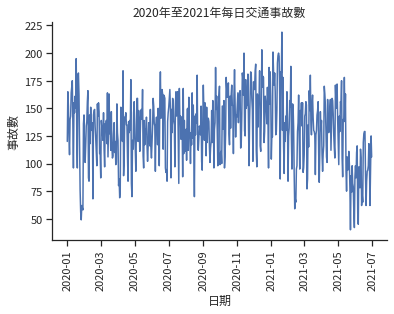

In [ ]:
# df.groupby(df.occur_datetime.dt.date).count()['acc_type'].plot()
df.groupby(df.occur_datetime.dt.date).sum()['all_acc'].plot()
plt.xticks(rotation=90)
plt.title('2020年至2021年每日交通事故數')
plt.xlabel('日期')
plt.ylabel('事故數')
plt.show()

## 每星期事故數

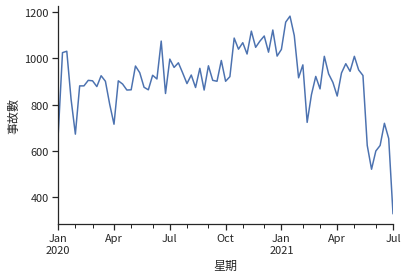

In [ ]:
df.set_index('occur_datetime').resample('W').count()['acc_type'].plot()
plt.xlabel('星期')
plt.ylabel('事故數')
plt.show()

# 模型
$y_t = \beta_0 + \beta_1 PostLockdown_t + \beta_2 Days_t + \beta_3 (Days_t \times PostLockdown_t) + W_t + u_t$

- $y_t$： The outcome of interest aggregated at the *daily level*.

- $PostLockdown_t$： One for all days after the lockdown and zero for all preceding days.

- $Days_t$： Number of days since the lockdown.

- $Days_t \times PostLockdown_t$： Interaction.

- $W_t$： Day-of-the-week fixed effects.

Report standard errors robust to heteroskedasticity.

In [ ]:
dfd = df.groupby(df.occur_datetime.dt.date).sum()[[var_name]].reset_index()
dfd.columns = ['Date', var_name]
dfd['Date'] = pd.to_datetime(dfd.Date)
dfd['Week'] = dfd.Date.dt.weekday + 1
dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(lockdown_date))
dfd['Days'] = (dfd.Date - pd.to_datetime(lockdown_date)).dt.days
dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', var_name]]

condition = (abs(dfd['Days']) <= bandwidth)
dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect


reg = plm.PanelOLS.from_formula(
        var_name + ' ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

results = reg.fit(cov_type="robust")
# results = reg.fit(cov_type='clustered', cluster_time=True)

print(results.summary)


dfd = dfd.assign(Pred = results.fitted_values)


ax = dfd.plot.scatter(x="Days", y=var_name, color="C0", marker="$\u25EF$")
dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
plt.axvline(x=0, color='grey', linewidth=1.3)
plt.title('Number: ' + var_name)
plt.ylabel('Number')
plt.show()

## 設定 LockDown日期 與 Bandwidth

In [ ]:
lockdown_date = '2021/05/11'
bandwidth = 50

## 設定模型變數

In [ ]:
dfd = df.groupby(df.occur_datetime.dt.date).count()[['acc_type']].reset_index()
dfd.columns = ['Date', 'Crash']
dfd['Date'] = pd.to_datetime(dfd.Date)
dfd['Week'] = dfd.Date.dt.weekday + 1
dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(lockdown_date))
dfd['Days'] = (dfd.Date - pd.to_datetime(lockdown_date)).dt.days
dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', 'Crash']]

condition = (abs(dfd['Days']) <= bandwidth)
dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect

dfd.tail()

,,Days,Postlockdown,Date,Crash
,Week,,,,
542,6,46,True,2021-06-26,104
543,7,47,True,2021-06-27,62
544,1,48,True,2021-06-28,96
545,2,49,True,2021-06-29,125
546,3,50,True,2021-06-30,106


## Model Summary

In [ ]:
reg = plm.PanelOLS.from_formula(
        'Crash ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

results = reg.fit(cov_type="robust")
# results = reg.fit(cov_type='clustered', cluster_time=True)

print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Crash   R-squared:                        0.5505
Estimator:                   PanelOLS   R-squared (Between):              0.3656
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Dec 26 2021   R-squared (Overall):              0.3656
Time:                        13:13:34   Log-likelihood                   -435.60
Cov. Estimator:                Robust                                           
                                        F-statistic:                      37.145
Entities:                         101   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             46.347
                            

In [ ]:
dfd = dfd.assign(Pred = results.fitted_values)

## Plot

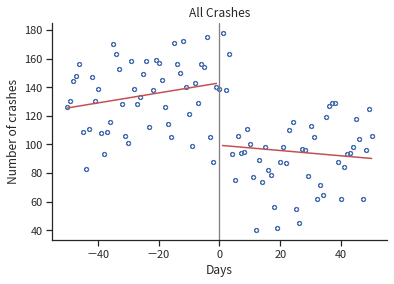

In [ ]:
ax = dfd.plot.scatter(x="Days", y="Crash", color="C0", marker="$\u25EF$")
dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
plt.axvline(x=0, color='grey', linewidth=1.3)
plt.title('All Crashes')
plt.ylabel('Number of crashes')
plt.show()

In [ ]:
display(dfd.shape)
dfd.tail()

(101, 5)

,,Days,Postlockdown,Date,Crash,Pred
entity,Week,,,,,
542,6,46,True,2021-06-26,104,90.969743
543,7,47,True,2021-06-27,62,90.784992
544,1,48,True,2021-06-28,96,90.600241
545,2,49,True,2021-06-29,125,90.415491
546,3,50,True,2021-06-30,106,90.230740


## Placebo Test (穩健性測試)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Crash   R-squared:                        0.1148
Estimator:                   PanelOLS   R-squared (Between):              0.0632
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Fri, Dec 10 2021   R-squared (Overall):              0.0632
Time:                        07:21:44   Log-likelihood                   -435.51
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.9345
Entities:                         101   P-value                           0.0109
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             3.6940
                            

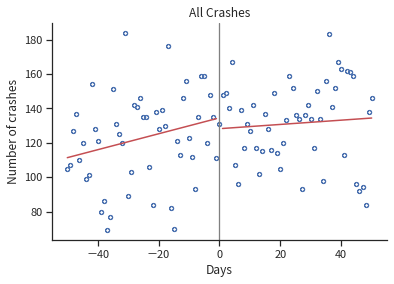

In [ ]:
lockdown_date = '2020/05/11'
bandwidth = 50


dfd = df.groupby(df.occur_datetime.dt.date).count()[['acc_type']].reset_index()
dfd.columns = ['Date', 'Crash']
dfd['Date'] = pd.to_datetime(dfd.Date)
dfd['Week'] = dfd.Date.dt.weekday + 1
dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(lockdown_date))
dfd['Days'] = (dfd.Date - pd.to_datetime(lockdown_date)).dt.days
dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', 'Crash']]

condition = (abs(dfd['Days']) <= bandwidth)
dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect


reg = plm.PanelOLS.from_formula(
        'Crash ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

results = reg.fit(cov_type="robust")
# results = reg.fit(cov_type='clustered', cluster_time=True)

print(results.summary)


dfd = dfd.assign(Pred = results.fitted_values)


ax = dfd.plot.scatter(x="Days", y="Crash", color="C0", marker="$\u25EF$")
dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
plt.axvline(x=0, color='grey', linewidth=1.3)
plt.title('All Crashes')
plt.ylabel('Number of crashes')
plt.show()

# 其他比例變數

## 建立變數

In [ ]:
df.cause_type.value_counts(ascending=False)
# 大類: 
# 駕駛人

df.cause_subtype.value_counts(ascending=False)
# 子類: 
# 未注意車前狀態
# 未依規定減速
# 超速失控
# 酒醉(後)駕駛失控

In [ ]:
df['a1_type'] = (df.acc_type=='A1')
df['cause_speed'] = ((df.cause_subtype=='未依規定減速') | (df.cause_subtype=='超速失控'))
df['cause_driver'] = ((df.cause_type=='駕駛人'))

In [ ]:
df.tail(2)

,acc_type,occur_datetime,start_datetime,end_datetime,county,town,death24_num,death30_num,hurt_num,weather,light,road_type,speed_limit,location_type,obstacle,accident_type,accident_subtype,cause_type,cause_subtype,party_order,nation,sex,age,vehicle_type,vehicle_subtype,injure_type,use_phone,action_type,driver_qualification,license_type,license_subtype,drink,hit_and_run,a1_type,cause_speed,cause_driver
71826,A2,2021-06-30 22:40:00,2021-06-30 22:40:00,2021-06-30 22:40:00,桃園市,桃園區,0.0,0,1,晴,夜間(或隧道、地下道、涵洞)無照明,市區道路,50,交叉路口,無障礙物,車與車,側撞,駕駛人,橫越道路不慎,1,1.0,男,30,小貨車(含客、貨兩用),自用,未受傷,未使用,迴轉或橫越道路中,有適當之駕照,普通駕照,小型車,經檢測無酒精反應,否,False,False,True
71827,A2,2021-06-30 23:11:00,2021-06-30 23:21:00,2021-06-30 23:41:00,桃園市,蘆竹區,0.0,0,1,晴,夜間(或隧道、地下道、涵洞)有照明,市區道路,50,路段,無障礙物,車與車,追撞,駕駛人,未注意車前狀態,1,1.0,男,24,小客車,租賃車,未受傷,未使用,向前直行中,有適當之駕照,職業駕照,小型車,經檢測無酒精反應,否,False,False,True


## 模型分析與繪圖

                          PanelOLS Estimation Summary                           
Dep. Variable:            cause_speed   R-squared:                        0.0538
Estimator:                   PanelOLS   R-squared (Between):              0.0446
No. Observations:                 101   R-squared (Within):               0.0000
Date:                Sun, Dec 26 2021   R-squared (Overall):              0.0446
Time:                        12:54:00   Log-likelihood                   -187.33
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.7260
Entities:                         101   P-value                           0.1672
Avg Obs:                       1.0000   Distribution:                    F(3,91)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1.3944
                            

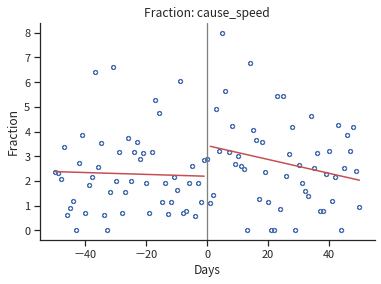

In [ ]:
lockdown_date = '2021/05/11'
bandwidth = 50

# 關心變數
var_name = 'cause_speed'

dfd = (df.groupby(df.occur_datetime.dt.date).mean()[[var_name]] * 100).reset_index()
dfd.columns = ['Date', var_name]
dfd['Date'] = pd.to_datetime(dfd.Date)
dfd['Week'] = dfd.Date.dt.weekday + 1
dfd['Postlockdown'] = (dfd.Date >= pd.to_datetime(lockdown_date))
dfd['Days'] = (dfd.Date - pd.to_datetime(lockdown_date)).dt.days
dfd = dfd[['Days', 'Postlockdown', 'Week', 'Date', var_name]]

condition = (abs(dfd['Days']) <= bandwidth)
dfd = dfd[condition].set_index('Week', append=True)  # for fixed effect


reg = plm.PanelOLS.from_formula(
        var_name + ' ~ 1 + Days + Postlockdown + Days:Postlockdown + TimeEffects',
        data=dfd)

results = reg.fit(cov_type="robust")
# results = reg.fit(cov_type='clustered', cluster_time=True)

print(results.summary)


dfd = dfd.assign(Pred = results.fitted_values)


ax = dfd.plot.scatter(x="Days", y=var_name, color="C0", marker="$\u25EF$")
dfd[dfd.Days<0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
dfd[dfd.Days>0].plot(x="Days", y="Pred", ax=ax, color="C3", legend=False)
plt.axvline(x=0, color='grey', linewidth=1.3)
plt.title('Fraction: ' + var_name)
plt.ylabel('Fraction')
plt.show()